In [48]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal

# !pip install pint
from pint import UnitRegistry
units = UnitRegistry(system = "mks")
units.default_format = "~P.2e"

### Constants and parameters

In [49]:
mu_0 = 1 * units.vacuum_permeability
N = 100
l = 18 * units.millimeter
R = 34 * units.millimeter / 2
I_original = 1 * units.amp
magnet_dipole = 0.44 * units.amp * units.meter ** 2
z_space = np.linspace(0 * units.mm, 100 * units.mm, 1000)
m = 9 * units.gram
g = 1 * units.standard_gravity
res = 0.1 * units.ohm
Fg = m * g

### B field equations
![B field equations](images/B_field_equations.png)
![F equations](images/F_equation.png)

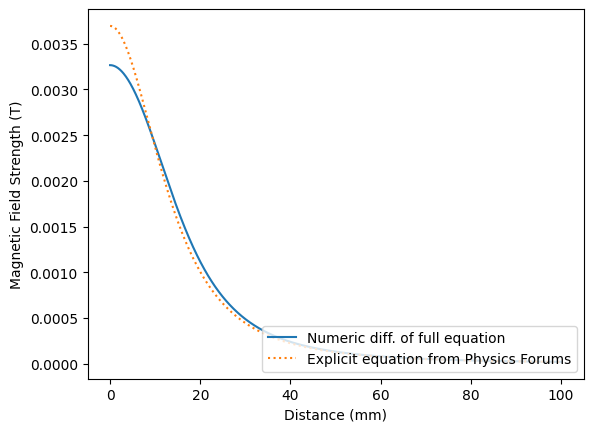

In [50]:
class AccurateModel:
    @classmethod
    def get_B_z_axis(cls, z, I):
        B_z_axis = mu_0 * N * I / 2 * (((l / 2 - z) / (l * np.sqrt(R ** 2 + (l / 2 - z) ** 2))) + ((l / 2 + z) / (l * np.sqrt(R ** 2 + (l / 2 + z) ** 2))))
        return B_z_axis
    @classmethod
    def get_F_z_axis(cls, z, I):
        dz = 0.05 * units.mm
        zs = np.linspace(z - dz, z + dz, 2)
        B_z_axis = cls.get_B_z_axis(zs, I)
        dBdz = (B_z_axis[1] - B_z_axis[0]) / dz
        F_z_axis = magnet_dipole * dBdz
        return F_z_axis
    @classmethod
    def get_F_z_axis_as_vector(cls, z, I):
        F_z_axis = np.zeros(np.size(z)) * units.newton
        for idx, z_val in enumerate(z):
            F_z_axis[idx] = cls.get_F_z_axis(z_val, I)
        return F_z_axis

class ShortSolenoidModel:
    @classmethod
    def get_B_z_axis(cls, z, I):
        B_short_solenoid_eq = mu_0 * I * N * R ** 2 / (2 * (R ** 2 + z ** 2) ** (3 / 2)) # From wikipedia: https://en.wikipedia.org/wiki/Solenoid#Short_solenoid_estimate
        return B_short_solenoid_eq
    @classmethod
    def get_F_z_axis(cls, z, I):
        F_short_solenoid_eq = -3 * mu_0 * R ** 2 * N * I * z / (2 * (R ** 2 + z ** 2) ** (5 / 2)) * magnet_dipole # From: https://www.physicsforums.com/insights/how-to-model-a-magnet-falling-through-a-conducting-pipe/
        return F_short_solenoid_eq

B_z_axis = AccurateModel.get_B_z_axis(z_space, I_original)
F_z_axis = AccurateModel.get_F_z_axis_as_vector(z_space, I_original)
B_short_solenoid_eq = ShortSolenoidModel.get_B_z_axis(z_space, I_original)
F_short_solenoid_eq = ShortSolenoidModel.get_F_z_axis(z_space, I_original)

plt.plot(z_space.to(units.mm), B_z_axis.to(units.tesla), label = "Numeric diff. of full equation")
plt.plot(z_space.to(units.mm), B_short_solenoid_eq.to(units.tesla), linestyle = "dotted", label = "Explicit equation from Physics Forums")
plt.xlabel("Distance (mm)")
plt.ylabel("Magnetic Field Strength (T)")
plt.legend(loc = "lower right")

### Linearizing the force

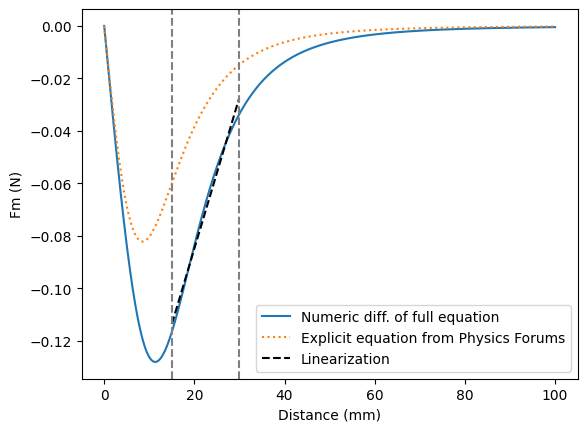

In [51]:
def linreg(x, y):
    A = np.vstack([x.magnitude, np.ones(len(x))]).T
    slope, intercept = np.linalg.lstsq(A, y.magnitude, rcond=None)[0]
    slope = slope * y.units / x.units
    intercept = intercept * y.units
    return slope, intercept

def linreg_points(x, y, start_lin_reg, end_lin_reg):
    lin_reg_range = (start_lin_reg <= x) & (x <= end_lin_reg)
    new_x = x[lin_reg_range]
    new_y = y[lin_reg_range]
    slope, intercept = linreg(new_x, new_y)
    return slope, intercept, new_x, new_x * slope + intercept

start_lin_reg = 15 * units.mm
end_lin_reg = 30 * units.mm
lin_reg_range = (start_lin_reg <= z_space) & (z_space <= end_lin_reg)
slope, intercept, z_lin_reg, Fm_lin_reg = linreg_points(z_space, F_z_axis, start_lin_reg, end_lin_reg)

plt.plot(z_space.to(units.mm), F_z_axis.to(units.newton), label = "Numeric diff. of full equation")
plt.plot(z_space.to(units.mm), F_short_solenoid_eq.to(units.newton), linestyle = "dotted", label = "Explicit equation from Physics Forums")
plt.plot(z_lin_reg.to(units.mm), Fm_lin_reg.to(units.newton), linestyle = "dashed", color = "black", label = "Linearization")
plt.xlabel("Distance (mm)")
plt.ylabel("Fm (N)")
plt.axvline(x = start_lin_reg.to(units.mm).magnitude, color = "grey", linestyle = "dashed")
plt.axvline(x = end_lin_reg.to(units.mm).magnitude, color = "grey", linestyle = "dashed")
plt.legend(loc = "lower right")

### Calculating Z0 and I0

In [52]:
z0 = 20 * units.mm

Fm_at_z0_given_original_I = np.interp(z0, z_lin_reg, Fm_lin_reg)
print(f"Force at z = z0 = {z0.to(units.mm)} given an original current of {I.to(units.amp)} is {Fm_at_z0_given_original_I.to(units.newton)}")
I0 = Fg / -Fm_at_z0_given_original_I * I
print(f"Current must be set to {I0.to(units.amp)} to achieve steady-state with a gravitational force of {Fg.to(units.N)}")

NameError: name 'I' is not defined

### Difference Equation

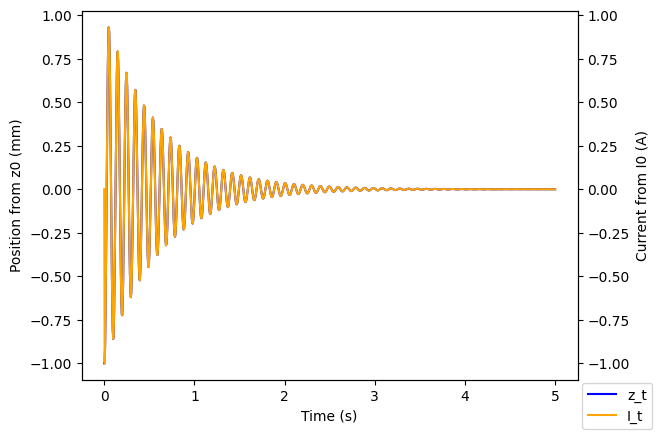

In [ ]:
# numeric solution
b = N * -9 * mu_0 ** 2 * magnet_dipole ** 2 * R ** 4 * z0 ** 2 / (4 * res * (R ** 2 + z0 ** 2) ** 5)
Fm0 = Fm_at_z0_given_original_I / I
a = slope * I0 / I

ts = np.linspace(0 * units.second, 5 * units.second, 1000)
dt = np.mean(np.diff(ts))
z_t = np.zeros(np.size(ts)) * units.mm
I_t = np.zeros(np.size(ts)) * units.amp
dzdt0 = 0 * units.mm / units.s
for n, t in enumerate(ts, start = -1):
    if n == -1:
        z_t[n + 1] = -1 * units.mm
    elif n == 0:
        z_t[n + 1] = z_t[0] + dzdt0 * dt
    elif n == len(ts) - 1:
        continue
    elif abs(z_t[n]) > 100 * units.mm:
        break
    else:
        I_t[n] = 1 * units.amp / units.mm * z_t[n]
        z_t[n + 1] = ((2 * z_t[n] - z_t[n - 1]) * m / dt ** 2 - b * (z_t[n] - z_t[n - 1]) / dt + a * z_t[n - 1] + I_t[n] * Fm0) / m * dt ** 2

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(ts, z_t.to(units.mm), color = "blue", label = "z_t")
ax2.plot(ts, I_t.to(units.amp), color = "orange", label = "I_t")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Position from z0 (mm)")
ax2.set_ylabel("Current from I0 (A)")
fig.legend(loc = "lower right")


### Physical model
Warning: overwriting the variables `z_t` and `I_t`

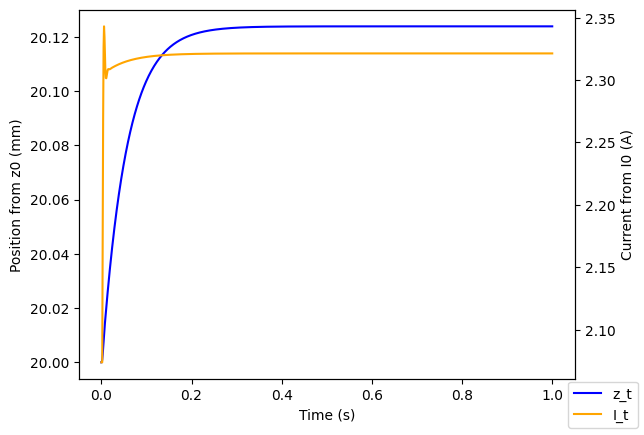

In [ ]:
ts = np.linspace(0 * units.second, 1 * units.second, 1000)
dt = np.mean(np.diff(ts))
z_t =    np.zeros(np.size(ts)) * units.mm
dzdt =   np.zeros(np.size(ts)) * units.mm / units.s
d2zdt2 = np.zeros(np.size(ts)) * units.mm / units.s ** 2
I_t = np.zeros(np.size(ts)) * units.amp
dzdt0 = 0 * units.mm / units.s
for n, t in enumerate(ts, start = 0):
    if n == 0:
        z_t[n] = z0
        I_t[n] = I0
    elif n == 1:
        z_t[n] = z_t[0] + dzdt0 * dt
        I_t[n] = I0
    elif abs(z_t[n]) > 100 * units.mm:
        break
    else:
        I_t[n] = I0 + 2 * units.amp / units.mm * (z_t[n - 1] - z0) + 0.1 * units.amp / units.mm * units.second * dzdt[n - 1]
        Fm = -3 * mu_0 * R ** 2 * N * I_t[n - 1] * z_t[n - 1] / (2 * (R ** 2 + z_t[n - 1] ** 2) ** (5 / 2)) * magnet_dipole
        Fl = N * -9 * mu_0 ** 2 * magnet_dipole ** 2 * R ** 4 * z_t[n - 1] ** 2 * dzdt[n - 1] / (4 * res * (R ** 2 + z_t[n - 1] ** 2) ** 5)
        Fg = m * g
        # print(f"{Fm.to(units.N) = }")
        # print(f"{Fl.to(units.N) = }")
        # print(f"{Fg.to(units.N) = }")
        # break
        Fnet = Fm + Fl + Fg
        d2zdt2[n] = Fnet / m
        dzdt[n] = dzdt[n - 1] + d2zdt2[n] * dt
        z_t[n] = z_t[n - 1] + dzdt[n] * dt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(ts, z_t.to(units.mm), color = "blue", label = "z_t")
ax2.plot(ts, I_t.to(units.amp), color = "orange", label = "I_t")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Position from z0 (mm)")
ax2.set_ylabel("Current from I0 (A)")
fig.legend(loc = "lower right")